# RAG Benchmark

Benchmark the different models.

In [1]:
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings, Collection
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os 
import requests

load_dotenv()


df = pd.read_csv("../data/processed-links.csv")
df.head()

,title,url,type,url_text,text_summary
0,informaticien cfc suisse,www.orientation.ch/dyn/show/1900?id=152,apprentissage,Informaticien CFC / Informaticienne CFC - orie...,L’informaticien CFC ou informaticienne CFC est...
1,école techniques des métiers de Lausanne,https://www.etml.ch/formation/em/informaticien...,école professionelle,Apprentissage d'informaticien·ne - ETML Nous u...,L’École technique des métiers de Lausanne (ETM...
2,école des métiers Fribourg,https://emf.ch/formation/informaticien-ne-cfc,école professionelle,Informaticien-ne CFC · Ecole des Métiers Fribo...,L’École des Métiers de Fribourg (EMF) propose ...
3,centre professionel du Nord Vaudois,https://www.cpnv.ch/formations/ecole-metiers/i...,école professionelle,Informaticien-ne CFC - CPNV Aller au contenu M...,Le Centre professionnel du Nord Vaudois (CPNV)...
4,université de fribourg,www.unifr.ch/inf/fr/informatique,université,Informatique | Département d'informatique | U...,L’Université de Fribourg propose un cursus com...


In [2]:
ids: list[str] = df["title"].to_list()
# switch here for the column you want to use
documents: list[str] = df["text_summary"].to_list()
metadatas: list[dict[str, str]] = df.loc[:, ["title", "type", "url"]].to_dict("records")

## Synthetic Questions Generation

In [3]:
PRODUCT_ID = os.getenv("PRODUCT_ID")
API_TOKEN = os.getenv("API_TOKEN")

BASE_URL = f"https://api.infomaniak.com/1/ai/{PRODUCT_ID}/openai/chat/completions"
HEADERS = {
    "Authorization": f"Bearer {API_TOKEN}",
    "Content-Type": "application/json"
}

BASIC_QA_PROMPT = """\
Le document contextuel est présenté ci-dessous :
---------------------
{context_str}
---------------------

Compte tenu des informations contextuelles et en l'absence de connaissances préalables,
générez uniquement des questions basées sur la requête ci-dessous.

Vous êtes enseignant/professeur. Votre tâche consiste à préparer \
{num_questions_per_chunk} questions pour un prochain \
quiz/examen. Les questions doivent être de nature variée \
à travers le document. Limitez les questions aux \
informations contextuelles fournies.
Générez des questions assez courtes, avec un vocabulaire simple.
"""

def generate_qa(document: str, num_questions: int = 1) -> str:
    input_seq = BASIC_QA_PROMPT.format(context_str=document, num_questions_per_chunk=num_questions)

    messages = [
            {"role": "user", "content": input_seq},
    ]
    payload = {
            "model": "qwen3",
            "messages": messages,
            "temperature": 0.6,
            "max_tokens": 50,
    }
    
    resp = requests.post(url=BASE_URL, json=payload, headers=HEADERS)
    result = resp.json()
    return result["choices"][0]["message"]["content"]

In [4]:
total = len(df)

questions_answer_pairs = []
for idx in df.index:
    print(f"[{idx + 1}|{total}]")
    
    row = df.iloc[idx]
    input_seq = ": ".join(row.loc[["title", "url_text"]].to_list())

    out = generate_qa(input_seq, num_questions=2)
    questions_answer_pairs.append((out, row.loc["title"]))

[1|25]
[2|25]
[3|25]
[4|25]
[5|25]
[6|25]
[7|25]
[8|25]
[9|25]
[10|25]
[11|25]
[12|25]
[13|25]
[14|25]
[15|25]
[16|25]
[17|25]
[18|25]
[19|25]
[20|25]
[21|25]
[22|25]
[23|25]
[24|25]
[25|25]


In [7]:
questions_list = [q.split("\n") for q, _ in questions_answer_pairs]
answers_list = [a for _, a in questions_answer_pairs]

filtered = []
for qs in questions_list:
    y = []
    for q in qs:
        if len(q) > 0:
            y.append(q)

    filtered.append(y)

questions_list = filtered

print(questions_list[0])
print([len(q) for q in questions_list])

['1. Quelles sont les deux orientations possibles pour un apprentissage d’informaticien CFC ?  ', '2. Combien d’années dure l’apprentissage d’informaticien CFC en entreprise ?']
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [47]:
q1s = [q1 for (q1, _) in questions_list]
q2s = [q2 for (_, q2) in questions_list]

len(q1s), len(q2s), len(answers_list)

(25, 25, 25)

In [57]:
qa_df = pd.DataFrame(list(zip(q1s, q2s, answers_list)), columns=["question_1", "question_2", "answers"])
qa_df.to_csv("../data/questions_answer.csv", header=True, index=False)

In [7]:
## load data here

qa_df = pd.read_csv("../data/questions_answer.csv")

q1 = qa_df["question_1"].to_list()
q2 = qa_df["question_2"].to_list()

answers_list = qa_df["answers"].to_list()
questions_list = [list(i) for i in zip(q1, q2)]

answers[0], questions_list[0]

('informaticien cfc suisse',
 ['1. Quelles sont les deux orientations possibles pour un apprentissage d’informaticien CFC ?  ',
  '2. Combien d’années dure l’apprentissage d’informaticien CFC en entreprise ?'])

## Measuring Perf

First two models are on infomaniak.
The rest we will need to train ourselves by getting the model with a GPU.

|evaluate? | Model name | Link |
|:--------:|------------|------|
| |MiniLM L12 v2 | https://developer.infomaniak.com/docs/api/post/1/ai/%7Bproduct_id%7D/openai/v1/embeddings |
| X |BGE Multilingual Gemma 2 | https://developer.infomaniak.com/docs/api/post/1/ai/%7Bproduct_id%7D/openai/v1/embeddings |
| X | paraphrase-multilingual-MiniLM-L12-v2 | https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 |
| X | paraphrase-multilingual-mpnet-base-v2 | https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2 |
| X | distiluse-base-multilingual-cased-v2 | https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2 |
|  | Alibaba-NLP/gte-Qwen2-1.5B-instruct | https://huggingface.co/Alibaba-NLP/gte-Qwen2-1.5B-instruct |
|  | BM25 | chromadb through `fastembed` | 

In [4]:
from sentence_transformers import SentenceTransformer

PRODUCT_ID = os.getenv("PRODUCT_ID")
API_TOKEN = os.getenv("API_TOKEN")


class MultinligualGemma2(EmbeddingFunction):
    def __init__(self, model_name: str) -> None:
        self.model_name = model_name
        self.url = f"https://api.infomaniak.com/1/ai/{PRODUCT_ID}/openai/v1/embeddings"
        self.headers = {
          'Authorization': f"Bearer {API_TOKEN}",
          'Content-Type': 'application/json',
        }
        
    def __call__(self, input_data: Documents) -> Embeddings:
        payload = {
            "input": input_data,
            "model": self.model_name,
        }

        req = requests.post(url=self.url, json=payload, headers=self.headers)
        res = req.json()
        data = res["data"]
        embeddings = [np.array(x["embedding"]) for x in data]
        
        return embeddings


# Do not evaluate this one
class MiniLML12V2(EmbeddingFunction):
    def __init__(self) -> None:
        self.model_name = "mini_lm_l12_v2"
        self.url = f"https://api.infomaniak.com/1/ai/{PRODUCT_ID}/openai/v1/embeddings"
        self.headers = {
          'Authorization': f"Bearer {API_TOKEN}",
          'Content-Type': 'application/json',
        }
        
    def __call__(self, input_data: Documents) -> Embeddings:
        payload = {
            "input": input_data,
            "model": self.model_name,
        }

        req = requests.post(url=self.url, json=payload, headers=self.headers)
        res = req.json()
        data = res["data"]
        embeddings = [np.array(x["embedding"]) for x in data]
        
        return embeddings


class SentenceTransformerFunction(EmbeddingFunction):
    def __init__(self, model_name: str) -> None:
        self.model_name = model_name
        self.model = SentenceTransformer(self.model_name)
        
    def __call__(self, input_data: Documents) -> Embeddings:
        embeddings = self.model.encode(input_data)
        return embeddings
        

# model we are interested in 
mini_lm_l12 = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" # 118M
mpnet_base = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2" # 278M
distule_base = "sentence-transformers/distiluse-base-multilingual-cased-v2" # 135M

collection_names = ["Gemma2", "MiniLM-L12", "MPNET-base", "Distule-base"]
model_names = ["bge_multilingual_gemma2", mini_lm_l12, mpnet_base, distule_base]
embedding_functions = [MultinligualGemma2, SentenceTransformerFunction, SentenceTransformerFunction, SentenceTransformerFunction]

DB_PATH = "../data/bench/"

client = chromadb.PersistentClient(path=DB_PATH)
# ensure the DB is available
print("hearbeat:", client.heartbeat())

/home/matt/Projects/py/hackhaton_lab/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


hearbeat: 1760263107384334624


In [10]:
def measure_perf(collection: Collection, questions_list:list[list[str]], answers_list: list[str], top_k: int = 5) -> int:
    score = 0
    for questions, answer in zip(questions_list, answers_list):
        results = collection.query(
            query_texts=questions,
            n_results=top_k,
        )

        # measure hit rate
        for ids in results["ids"]:
            if answer in ids:
                score += 1
                
    return score


TOP_K = 5
scores = []
total_questions = sum([len(q) for q in questions_list])

iters = 0
for name, model_name, embedding_func in zip(collection_names, model_names, embedding_functions):
    print("iter:", iters)
    name_k = name + "_k_" + str(TOP_K)
    collection = client.create_collection(
        name=name_k,
        embedding_function=embedding_func(model_name),
    )
    print("Adding docs...")
    collection.add(
        ids=ids,
        metadatas=metadatas,
        documents=documents,
    )
    print("Benchmarking...")
    score = measure_perf(collection, questions_list, answers_list, top_k=TOP_K)

    scores.append(score)
    iters += 1


print(scores)

iter: 0
Adding docs...
Benchmarking...
iter: 1
Adding docs...
Benchmarking...
iter: 2
Adding docs...
Benchmarking...
iter: 3
Adding docs...
Benchmarking...
[43, 36, 32, 33]


In [11]:
TOP_K = 3
scores_k_3 = []
total_questions = sum([len(q) for q in questions_list])

iters = 0
for name, model_name, embedding_func in zip(collection_names, model_names, embedding_functions):
    print("iter:", iters)
    name_k = name + "_k_" + str(TOP_K)
    collection = client.create_collection(
        name=name_k,
        embedding_function=embedding_func(model_name),
    )
    print("Adding docs...")
    collection.add(
        ids=ids,
        metadatas=metadatas,
        documents=documents,
    )
    print("Benchmarking...")
    score = measure_perf(collection, questions_list, answers_list, top_k=TOP_K)

    scores_k_3.append(score)
    iters += 1


print(scores_k_3)

iter: 0
Adding docs...
Benchmarking...
iter: 1
Adding docs...
Benchmarking...
iter: 2
Adding docs...
Benchmarking...
iter: 3
Adding docs...
Benchmarking...
[37, 33, 30, 30]


In [31]:
TOP_K = 10
scores_k_10 = []
total_questions = sum([len(q) for q in questions_list])

iters = 0
for name, model_name, embedding_func in zip(collection_names, model_names, embedding_functions):
    print("iter:", iters)
    name_k = name + "_k_" + str(TOP_K)
    collection = client.create_collection(
        name=name_k,
        embedding_function=embedding_func(model_name),
    )
    print("Adding docs...")
    collection.add(
        ids=ids,
        metadatas=metadatas,
        documents=documents,
    )
    print("Benchmarking...")
    score = measure_perf(collection, questions_list, answers_list, top_k=TOP_K)

    scores_k_10.append(score)
    iters += 1


print(scores_k_10)

iter: 0
Adding docs...
Benchmarking...
iter: 1
Adding docs...
Benchmarking...
iter: 2
Adding docs...
Benchmarking...
iter: 3
Adding docs...
Benchmarking...
[46, 43, 37, 39]


In [52]:
collection_names

['Gemma2', 'MiniLM-L12', 'MPNET-base', 'Distule-base']

In [73]:
test = client.get_collection("Gemma2_k_5", embedding_function=embedding_functions[0](model_names[0]))

In [74]:
%%time

results = test.query(
    query_texts=questions_list[0][1],
    n_results=5,
)

CPU times: user 48.1 ms, sys: 1.96 ms, total: 50.1 ms
Wall time: 345 ms


In [75]:
test = client.get_collection("MiniLM-L12_k_5", embedding_function=embedding_functions[1](model_names[1]))

In [76]:
%%time

results = test.query(
    query_texts=questions_list[0][1],
    n_results=5,
)

CPU times: user 75.6 ms, sys: 5.91 ms, total: 81.6 ms
Wall time: 25.8 ms


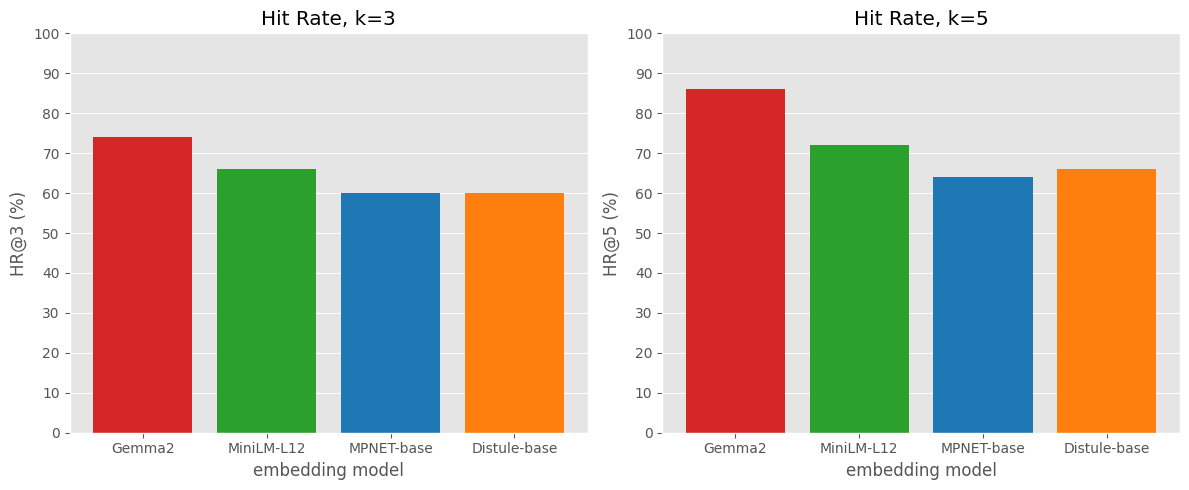

In [86]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

K = 3


plt.figure(figsize=(12, 5), layout="tight")

plt.subplot(1, 2, 1)

x = (np.array(scores_k_3) / total_questions) * 100
bar_colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']
plt.bar(collection_names, x, color=bar_colors)
plt.ylim(0, 100)
plt.ylabel(f"HR@{K} (%)")
plt.xlabel("embedding model")
plt.yticks(np.arange(0, 101, 10))
plt.title(f"Hit Rate, k={K}")

plt.grid(False)
plt.grid(True, axis="y")

plt.subplot(1, 2, 2)
K = 5
x = (np.array(scores) / total_questions) * 100
bar_colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']
plt.bar(collection_names, x, color=bar_colors)
plt.ylim(0, 100)
plt.ylabel(f"HR@{K} (%)")
plt.xlabel("embedding model")

plt.yticks(np.arange(0, 101, 10))

plt.title(f"Hit Rate, k={K}")

plt.grid(False)
plt.grid(True, axis="y")
plt.savefig("results.png", dpi=200)